## Let’s build! Nudged elastic band method from first principles

### The nudged elastic band method

Nudged elastic band method, or NEB for short, is an algorithm to find a minimum energy pathway between two point on a multi-dimensional potential energy surface (PES). The idea is to span the pathway on the PES between the initial and final points into increments, each point (or image) on the pathway connected to one another via a spring force. The energy of the overall path (or band, since the path is essentially elastic due to the spring force) is then minimized. After optimization, the band should lie along the minimum energy pathway (MEP).

In this tutorial, we'll construct and apply an NEB procedure to a simple two dimensional potential energy surface, defined as

$$V(x,y) = \exp\left[-\cos(2\pi x) - \cos(\pi (y-x))\right] - \exp\left[-\cos(2\pi y)\right].$$

We'll use the *climbing image* variant of NEB, where we'll find the saddle point along the minimum energy path that corresponds to the highest peak along the path.

### The NEB procedure

In NEB, we first define two close lying minima on the PES and construct an initial guess for the MEP. The guess is often done via interpolation. The idea in NEB is to perform energy minization on each image of the reaction path, but remove the force component along the NEB path with a spring force. Why? If we were just to minimize the energy without the spring force, all the images would slide down the potential energy surface to the nearest minimum. The spring force binds the neighbouring images together and prevents them from moving too far apart. The spring force acts only along the path defined by the images. Orthogonal to the path we use the actual force acting on the images to minimize the energy. This way the band will aling itself with the shape of the potential energy surface. 

There are several way to define **the path** of the NEB band. Here, we'll define it as the difference between the given image $i$ and the neighbours before and after it depending on what is the relative energies of the images:

$$\hat{\tau}_i = \begin{cases}
\tau^+_i &= \mathbf{R}_{i+1}-\mathbf{R}_{i} \;,\;\;\text{if} \;E(\mathbf{R}_{i+1}) >E(\mathbf{R}_{i}) > E(\mathbf{R}_{i-1}), \\
\tau^-_i &= \mathbf{R}_{i}-\mathbf{R}_{i-1} \;,\;\;\text{if} \;E(\mathbf{R}_{i+1}) <E(\mathbf{R}_{i}) < E(\mathbf{R}_{i-1}). \\
\end{cases}$$

If the potential energy of image $i$ is an extremum, the path is then $\tau = \mathbf{R}_{i+1}-\mathbf{R}_{i-1}$. The pathvector is normalized.

The forces acting on each image are divided into two orthogonal components, one parallel to the path and one orthogonal:

$$\mathbf{F}_i = \mathbf{F}_{i,\parallel} + \mathbf{F}_{i,\perp}.$$

The parallel path is defined as a spring force that will ensure that the images do not all just fall down the PES to the their closest minimum:

$$\mathbf{F}_{i,\parallel} = k(|\textbf{R}_{i+1}-\mathbf{R}_{i}| - |\mathbf{R}_{i}-\mathbf{R}_{i-1}|)\hat{\tau}_i,$$

where $k$ is the spring constant for the harmonic force. The orthogonal component is obtained from the the 'real' force acting on the system, i.e. the force we get as the gradient of the potential energy:

$$\mathbf{F} = -\nabla V(\mathbf{R}_i).$$

To retain only the orthogonal component to the path vector $\tau_i$, we need to remove the projection of the force parallel to the path:

$$\mathbf{F}_{i,\perp} = -\nabla V(\mathbf{R}_i) + \left[\nabla V(\mathbf{R}_i)\cdot \hat{\tau}_i \right] \hat{\tau}_i.$$

In the *climbing image* (CI) NEB, the image with the highest energy is not subjest to the spring force. Instead, it will try to **climb up** the potential energy surface instead of going down. This means that the component parallel to the NEB path will be reversed:

$$\mathbf{F}_{i, \text{max}} = -\nabla V(\mathbf{R}_{i, \text{max}}) + \left[2\nabla V(\mathbf{R}_{i, \text{max}})\cdot \hat{\tau}_{i, \text{max}}\right] \hat{\tau}_{i, \text{max}}.$$

### Building NEB for a 2D potential

We'll use the steepest descent method with a fixed step size to minimize the energy of the band. In steepest descent, we follow the direction of the steepest descent (i.e. the force vector) and update the coordinates of each image consecutively using a fixed step size. 

In addition to Numpy, we'll use Sympy library for symbolic calculation to do the partial derivatives of the potential function. Let's begin by defining the potential energy surface for our system. 

In [1]:
import sympy as sp
from IPython.display import display

# Define symbolic variables
x, y = sp.symbols('x y')
# Define the function V(x, y)
V_sp = sp.exp(-sp.cos(2*sp.pi*x) - sp.cos(sp.pi*(y-x))) - sp.exp(-sp.cos(sp.pi*y))

Next, we'll compute the partial derivatives of the potential energy function and convert the experssions into a separate functions using the *lambdify*-function. We can then readily use these functions in our NEB procedure. We can use the *latex*-function in Sympy to print out Latex expressions for our partial derivatives. A similar *python* or *print_python* function would give an expression in Python that could then be defined separately.

In [2]:
# Compute the partial derivatives using Sympy
dVx_sp = sp.diff(V_sp, x)
dVy_sp = sp.diff(V_sp, y)
# Lambdify the expressions
V = sp.lambdify((x, y), V_sp, 'numpy')
dVx = sp.lambdify((x, y), dVx_sp, 'numpy')
dVy = sp.lambdify((x, y), dVy_sp, 'numpy')

print(sp.latex(dVx_sp))
print(sp.latex(dVy_sp))

\left(2 \pi \sin{\left(2 \pi x \right)} - \pi \sin{\left(\pi \left(- x + y\right) \right)}\right) e^{- \cos{\left(2 \pi x \right)} - \cos{\left(\pi \left(- x + y\right) \right)}}
\pi e^{- \cos{\left(2 \pi x \right)} - \cos{\left(\pi \left(- x + y\right) \right)}} \sin{\left(\pi \left(- x + y\right) \right)} - \pi e^{- \cos{\left(\pi y \right)}} \sin{\left(\pi y \right)}


The partial derivatives are then:

$$\frac{\partial V}{\partial x} = \left(2 \pi \sin{\left(2 \pi x \right)} - \pi \sin{\left(\pi \left(- x + y\right) \right)}\right) e^{- \cos{\left(2 \pi x \right)} - \cos{\left(\pi \left(- x + y\right) \right)}}$$

$$\frac{\partial V}{\partial y} = \pi e^{- \cos{\left(2 \pi x \right)} - \cos{\left(\pi \left(- x + y\right) \right)}} \sin{\left(\pi \left(- x + y\right) \right)} - \pi e^{- \cos{\left(\pi y \right)}} \sin{\left(\pi y \right)}$$

Finally, let's plot the potential energy surface as a contour plot. The points $[0,1]$ and $[1,1]$ are two minima on the PES. We'll be using these as the initial and final points, respectively. We'll mark these two points down using a red dot.

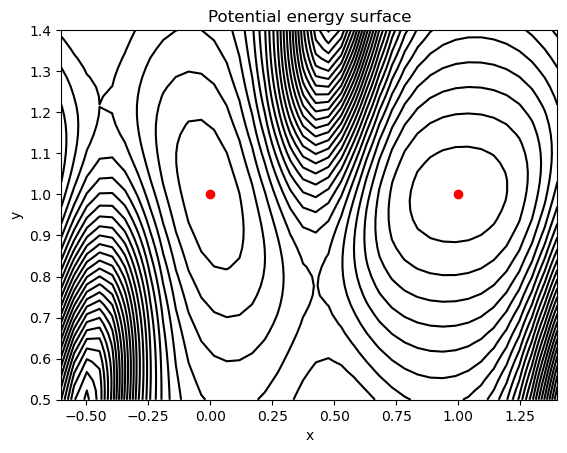

In [3]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-0.6, 1.4, 40)
y = np.linspace(0.5, 1.4, 40)
X, Y = np.meshgrid(x, y)
Z = V(X,Y)

fig, ax = plt.subplots()
ax.contour(X, Y, Z, 30, colors='black', linestyles='solid')
ax.scatter([0,1], [1,1], color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Potential energy surface')
plt.show()

We'll begin by defining an initial guess for the minimum energy path. A good initial guess is crucial for the accuracy of the minimum energy path, since we really only relax the initial guess and do not explore the potential energy surface beyond our guess. A linear interpolation between the initial and final states is a common approximation.

In [4]:
# Initial state (0,1)
# Final state (1,1)

nimg = 16 # Number of images
init = np.array([0,1]) # Initial state on the PES
final = np.array([1,1]) # Final state on the PES

# Interpolate path, save full path to images
images = [init]
for img in range(1,nimg+1):
    images.append(init - (init-final) / (nimg+1) * (img))
images.append(final)
images = np.array(images)

Next, we'll initialize the forces and energies of the system. The forces will be used in our **steepest descent** optimization scheme and the energies are used for defining the path vector and for choosing the climbing image, each cycle.

In [5]:
# List of forces on all images (init and final states will remain stationary)
forces = np.zeros((len(images),2))
energies = np.zeros((len(images),))
# Compute energies for the initial and final states
energies[0] = V(images[0,0], images[0,1])
energies[-1] = V(images[-1,0], images[-1,1])

Next, we'll define the NEB procedure. First, we'll evaluate the energy of each image and then loop over all the images in our band and,
1. Construct the path vector
2. Normalize the path vector
3. Compute the *real* force
4. Compute the spring force
5. Apply the forces in the optimization

In [6]:
# NEB parameters
step_size = 0.01 # Step size for optimisation1
k = 0.005 # Spring constant for the harmonic force

initial_images = images.copy() # Copy the initial guess for the path
real_force = np.zeros((2,))
path_history = [images.copy()] # Record the pathway from beginning to end, for plotting purposes
for step in range(70): # Run the optimisation for some fixed amount of steps
    for i in range(1, len(images)-1):
        x, y = images[i]
        energies[i] = V(x,y)
    for i in range(1, len(images)-1):
        x, y = images[i]

        # Construct the path vector
        if energies[i] > energies[i-1] and energies[i] < energies[i+1]:
            path = images[i+1] -  images[i]
        elif energies[i] < energies[i-1] and energies[i] > energies[i+1]:
            path = images[i] -  images[i-1]
        else:
            path = images[i+1] - images[i-1]
        path /= np.linalg.norm(path) # Normalize the path vector

        real_force = -np.array([dVx(x,y), dVy(x,y)]) # Compute the real force
        spring_force = k * (np.linalg.norm(images[i+1]-images[i]) - np.linalg.norm(images[i]-images[i-1])) * path # Compute the spring force
        # Steepest descent optimization
        if energies[i] == np.max(energies): # If the image has the highest potential energy, use the climbing image procedure
            forces[i] = real_force - 2 * np.dot(real_force, path) * path
        else: # Else, use only the orthogonal component of the real force and the spring force
            forces[i] = real_force - np.dot(real_force, path) * path + spring_force
        
    if np.max(np.sum(forces**2, axis=1)**0.5) < 0.05:
        break

    images[1:-1] += step_size * forces[1:-1] / np.linalg.norm(forces[1:-1]) # Steepest descent optimisation
    path_history.append(images.copy())

xopt, yopt = images[energies == np.max(energies)][0]
eopt = energies[energies == np.max(energies)][0]
print(f"NEB saddlepoint at ({xopt: .3f}, {yopt: .3f}) with energy {eopt: 0.7f}")
print(f"Exact saddlepoint at (0.427, 0.777) with energy {V(0.427, 0.777): 0.7f}")

NEB saddlepoint at ( 0.427,  0.775) with energy -0.5910029
Exact saddlepoint at (0.427, 0.777) with energy -0.5910308


We find a saddle point very close to an exact solution. Let's plot our initial and the optimized NEB paths on the potential energy surface.

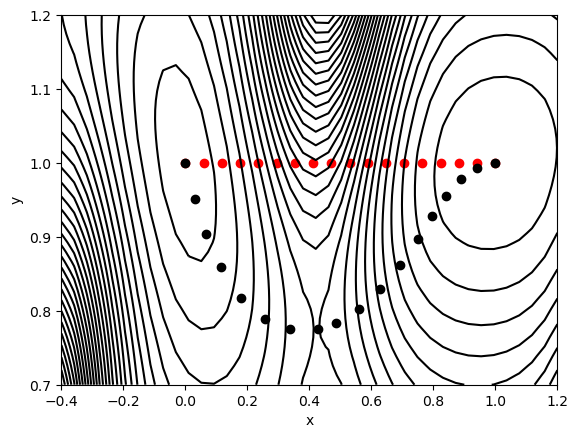

In [7]:
import matplotlib.pyplot as plt

x = np.linspace(-0.4, 1.2, 40)
y = np.linspace(0.7, 1.2, 40)
X, Y = np.meshgrid(x, y)
Z = V(X,Y)

fig, ax = plt.subplots()
ax.contour(X, Y, Z, 40, colors='black', linestyles='solid')
ax.scatter(initial_images[:,0], initial_images[:,1], color='r')
ax.scatter(images[:,0], images[:,1], cmap='binary', color='black')
ax.set_xlabel('x')
ax.set_ylabel('y')
#fig.savefig('plot.png')
plt.show()

Let's animate the path to see how the band relaxes onto the minimum energy path.

In [8]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Ensure that animations are rendered inline
%matplotlib inline

fig, ax = plt.subplots()
contour = ax.contour(X, Y, Z, 40, colors='black', linestyles='solid')
scatter_initial = ax.scatter([], [], color='r')
scatter_images = ax.scatter([], [], color='black')
plt.close(fig)

def data_from_history(iteration):
    if iteration < len(path_history):
        return path_history[0], path_history[iteration]
    else:
        return path_history[0], path_history[-1]

# Update function for animation
def update(frame):
    initial_images, images = data_from_history(frame)
    scatter_initial.set_offsets(initial_images)
    scatter_images.set_offsets(images)
    return scatter_initial, scatter_images,

# Create animation
ani = FuncAnimation(fig, update, frames=range(80), blit=True)
HTML(ani.to_html5_video())

The initial movement is largest where the gradient is largest (the points on top of the high energy ridge). The highest energy point slides down towards the saddle point. After the gradient acting on the highest energy images decreases, all the point start to relax. The spacing between the points is not uniform. Where the potential energy is relatively flat, the points have larger freedom of movement and align themselves with the contours of the potential energy surface with larger spacing between the points.